# Build a Question/Answering system over SQL data



> Enabling a LLM system to query structured data can be qualitatively different from unstructured text data. Whereas in the latter it is common to generate text that can be searched against a vector database, the approach for structured data is often for the LLM to write and execute queries in a DSL, such as SQL. In this guide we'll go over the basic ways to create a Q&A system over tabular data in databases. We will cover implementations using both chains and agents. These systems will allow us to ask a question about the data in a database and get back a natural language answer. The main difference between the two is that our agent can query the database in a loop as many times as it needs to answer the question.



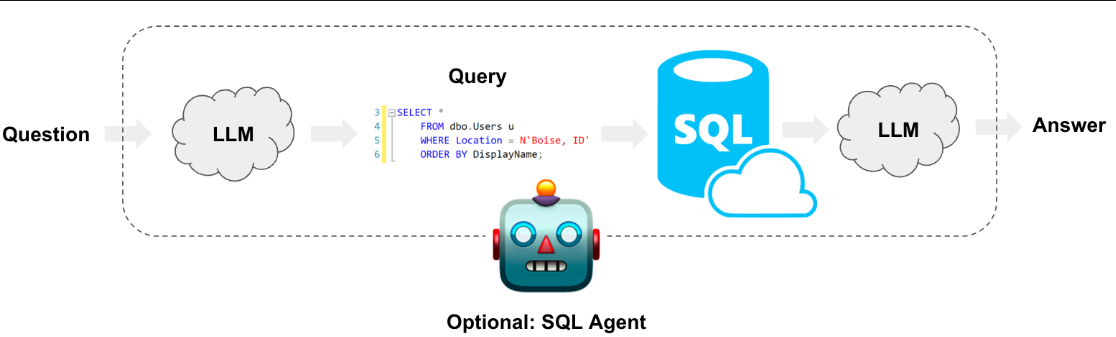

In [1]:
%%capture --no-stderr
%pip install --upgrade --quiet langchain-community langgraph

In [2]:
import os
import getpass

In [3]:
# Comment out the below to opt-out of using LangSmith in this notebook. Not required.
if not os.environ.get("LANGSMITH_API_KEY"):
    os.environ["LANGSMITH_API_KEY"] = getpass.getpass()
    os.environ["LANGSMITH_TRACING"] = "true"

··········


In [4]:
# write this in a code cell (%%bash) or prefix with ! in a Python cell
!wget -O /content/Chinook_Sqlite.sqlite "https://github.com/lerocha/chinook-database/raw/master/ChinookDatabase/DataSources/Chinook_Sqlite_AutoIncrementPKs.sqlite"
!ls -lh /content/Chinook_Sqlite.sqlite


--2025-08-13 22:50:06--  https://github.com/lerocha/chinook-database/raw/master/ChinookDatabase/DataSources/Chinook_Sqlite_AutoIncrementPKs.sqlite
Resolving github.com (github.com)... 140.82.112.3
Connecting to github.com (github.com)|140.82.112.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/lerocha/chinook-database/master/ChinookDatabase/DataSources/Chinook_Sqlite_AutoIncrementPKs.sqlite [following]
--2025-08-13 22:50:06--  https://raw.githubusercontent.com/lerocha/chinook-database/master/ChinookDatabase/DataSources/Chinook_Sqlite_AutoIncrementPKs.sqlite
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1067008 (1.0M) [application/octet-stream]
Saving to: ‘/content/Chinook_Sqlite.sqlite’

/co

In [5]:
import sqlite3
import pandas as pd

db_path = "/content/Chinook_Sqlite.sqlite"   # change if you saved elsewhere
conn = sqlite3.connect(db_path)

tables_df = pd.read_sql_query("SELECT name FROM sqlite_master WHERE type='table' ORDER BY name;", conn)
print("Tables in DB:")
display(tables_df)


Tables in DB:


,name
0,Album
1,Artist
2,Customer
3,Employee
4,Genre
5,Invoice
6,InvoiceLine
7,MediaType
8,Playlist
9,PlaylistTrack


In [6]:
from langchain_community.utilities import SQLDatabase

db = SQLDatabase.from_uri("sqlite:////content/Chinook_Sqlite.sqlite")  # note 4 slashes for absolute path

print(db.dialect)


sqlite


In [7]:
print(db.get_usable_table_names())


['Album', 'Artist', 'Customer', 'Employee', 'Genre', 'Invoice', 'InvoiceLine', 'MediaType', 'Playlist', 'PlaylistTrack', 'Track']


In [8]:
db.run("SELECT * FROM Artist LIMIT 10;")

"[(1, 'AC/DC'), (2, 'Accept'), (3, 'Aerosmith'), (4, 'Alanis Morissette'), (5, 'Alice In Chains'), (6, 'Antônio Carlos Jobim'), (7, 'Apocalyptica'), (8, 'Audioslave'), (9, 'BackBeat'), (10, 'Billy Cobham')]"

# Chains



> Chains are compositions of predictable steps. In LangGraph, we can represent a chain via simple sequence of nodes. Let's create a sequence of steps that, given a question, does the following:


*   converts the question into a SQL query;
*   executes the query;
*   uses the result to answer the original question.








In [9]:
from typing_extensions import TypedDict


class State(TypedDict):
    question: str
    query: str
    result: str
    answer: str

Convert question to SQL query

In [10]:
%pip install -qU "langchain[google-genai]"

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.4/49.4 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 18.1 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-generativeai 0.8.5 requires google-ai-generativelanguage==0.6.15, but you have google-ai-generativelanguage 0.6.18 which is incompatible.


In [11]:
import getpass
import os

if not os.environ.get("GOOGLE_API_KEY"):
  os.environ["GOOGLE_API_KEY"] = getpass.getpass("Enter API key for Google Gemini: ")

from langchain.chat_models import init_chat_model

llm = init_chat_model("gemini-2.5-flash", model_provider="google_genai")

Enter API key for Google Gemini: ··········


In [12]:
from langchain_core.prompts import ChatPromptTemplate

system_message = """
Given an input question, create a syntactically correct {dialect} query to
run to help find the answer. Unless the user specifies in his question a
specific number of examples they wish to obtain, always limit your query to
at most {top_k} results. You can order the results by a relevant column to
return the most interesting examples in the database.

Never query for all the columns from a specific table, only ask for a the
few relevant columns given the question.

Pay attention to use only the column names that you can see in the schema
description. Be careful to not query for columns that do not exist. Also,
pay attention to which column is in which table.

Only use the following tables:
{table_info}
"""

user_prompt = "Question: {input}"

query_prompt_template = ChatPromptTemplate(
    [("system", system_message), ("user", user_prompt)]
)

for message in query_prompt_template.messages:
    message.pretty_print()

================================ System Message ================================


Given an input question, create a syntactically correct {dialect} query to
run to help find the answer. Unless the user specifies in his question a
specific number of examples they wish to obtain, always limit your query to
at most {top_k} results. You can order the results by a relevant column to
return the most interesting examples in the database.

Never query for all the columns from a specific table, only ask for a the
few relevant columns given the question.

Pay attention to use only the column names that you can see in the schema
description. Be careful to not query for columns that do not exist. Also,
pay attention to which column is in which table.

Only use the following tables:
{table_info}

================================ Human Message =================================

Question: {input}




> The prompt includes several parameters we will need to populate, such as the SQL dialect and table schemas. LangChain's SQLDatabase object includes methods to help with this. Our write_query step will just populate these parameters and prompt a model to generate the SQL query:



In [13]:
from typing_extensions import Annotated


class QueryOutput(TypedDict):
    """Generated SQL query."""

    query: Annotated[str, ..., "Syntactically valid SQL query."]


def write_query(state: State):
    """Generate SQL query to fetch information."""
    prompt = query_prompt_template.invoke(
        {
            "dialect": db.dialect,
            "top_k": 10,
            "table_info": db.get_table_info(),
            "input": state["question"],
        }
    )
    structured_llm = llm.with_structured_output(QueryOutput)
    result = structured_llm.invoke(prompt)
    return {"query": result["query"]}

In [14]:
write_query({"question": "How many Employees are there?"})

{'query': 'SELECT COUNT(*) FROM Employee;'}

# Execute query



> This is the most dangerous part of creating a SQL chain. Consider carefully if it is OK to run automated queries over your data. Minimize the database connection permissions as much as possible. Consider adding a human approval step to you chains before query execution (see below).

To execute the query, we will load a tool from langchain-community. Our execute_query node will just wrap this tool:



In [15]:
from langchain_community.tools.sql_database.tool import QuerySQLDatabaseTool


def execute_query(state: State):
    """Execute SQL query."""
    execute_query_tool = QuerySQLDatabaseTool(db=db)
    return {"result": execute_query_tool.invoke(state["query"])}

In [16]:
execute_query({"query": "SELECT COUNT(EmployeeId) AS EmployeeCount FROM Employee;"})

{'result': '[(8,)]'}

# Generate answer

In [17]:
def generate_answer(state: State):
    """Answer question using retrieved information as context."""
    prompt = (
        "Given the following user question, corresponding SQL query, "
        "and SQL result, answer the user question.\n\n"
        f"Question: {state['question']}\n"
        f"SQL Query: {state['query']}\n"
        f"SQL Result: {state['result']}"
    )
    response = llm.invoke(prompt)
    return {"answer": response.content}




> Finally, we compile our application into a single graph object. In this case, we are just connecting the three steps into a single sequence.



In [18]:
from langgraph.graph import START, StateGraph

graph_builder = StateGraph(State).add_sequence(
    [write_query, execute_query, generate_answer]
)
graph_builder.add_edge(START, "write_query")
graph = graph_builder.compile()

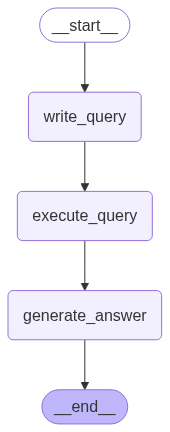

In [19]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [20]:
for step in graph.stream(
    {"question": "How many employees are there?"}, stream_mode="updates"
):
    print(step)

{'write_query': {'query': 'SELECT COUNT(*) FROM Employee;'}}
{'execute_query': {'result': '[(8,)]'}}
{'generate_answer': {'answer': 'There are 8 employees.'}}


# Human-in-the-loop


> LangGraph supports a number of features that can be useful for this workflow. One of them is human-in-the-loop: we can interrupt our application before sensitive steps (such as the execution of a SQL query) for human review. This is enabled by LangGraph's persistence layer, which saves run progress to your storage of choice. Below, we specify storage in-memory



In [21]:
from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()
graph = graph_builder.compile(checkpointer=memory, interrupt_before=["execute_query"])

# Now that we're using persistence, we need to specify a thread ID
# so that we can continue the run after review.
config = {"configurable": {"thread_id": "1"}}

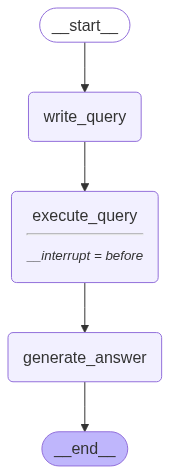

In [22]:
display(Image(graph.get_graph().draw_mermaid_png()))

In [24]:
for step in graph.stream(
    {"question": "How many employees are there?"},
    config,
    stream_mode="updates",
):
    print(step)

try:
    user_approval = input("Do you want to go to execute query? (yes/no): ")
except Exception:
    user_approval = "no"

if user_approval.lower() == "yes":
    # If approved, continue the graph execution
    for step in graph.stream(None, config, stream_mode="updates"):
        print(step)
else:
    print("Operation cancelled by user.")

{'write_query': {'query': 'SELECT COUNT(EmployeeId) FROM Employee'}}
{'__interrupt__': ()}
Do you want to go to execute query? (yes/no): rth
Operation cancelled by user.


# AGENTS

Agents leverage the reasoning capabilities of LLMs to make decisions during execution. Using agents allows you to offload additional discretion over the query generation and execution process. Although their behavior is less predictable than the above "chain", they feature some advantages:


*   They can query the database as many times as needed to answer the user questioN.
*   They can recover from errors by running a generated query, catching the traceback and regenerating it correctly.
*   They can answer questions based on the databases' schema as well as on the databases' content (like describing a specific table)





In [25]:
from langchain_community.agent_toolkits import SQLDatabaseToolkit

toolkit = SQLDatabaseToolkit(db=db, llm=llm)

tools = toolkit.get_tools()

tools

[QuerySQLDatabaseTool(description="Input to this tool is a detailed and correct SQL query, output is a result from the database. If the query is not correct, an error message will be returned. If an error is returned, rewrite the query, check the query, and try again. If you encounter an issue with Unknown column 'xxxx' in 'field list', use sql_db_schema to query the correct table fields.", db=<langchain_community.utilities.sql_database.SQLDatabase object at 0x7d35fa59e710>),
 InfoSQLDatabaseTool(description='Input to this tool is a comma-separated list of tables, output is the schema and sample rows for those tables. Be sure that the tables actually exist by calling sql_db_list_tables first! Example Input: table1, table2, table3', db=<langchain_community.utilities.sql_database.SQLDatabase object at 0x7d35fa59e710>),
 ListSQLDatabaseTool(db=<langchain_community.utilities.sql_database.SQLDatabase object at 0x7d35fa59e710>),
 QuerySQLCheckerTool(description='Use this tool to double check

In [26]:
system_message = """
You are an agent designed to interact with a SQL database.
Given an input question, create a syntactically correct {dialect} query to run,
then look at the results of the query and return the answer. Unless the user
specifies a specific number of examples they wish to obtain, always limit your
query to at most {top_k} results.

You can order the results by a relevant column to return the most interesting
examples in the database. Never query for all the columns from a specific table,
only ask for the relevant columns given the question.

You MUST double check your query before executing it. If you get an error while
executing a query, rewrite the query and try again.

DO NOT make any DML statements (INSERT, UPDATE, DELETE, DROP etc.) to the
database.

To start you should ALWAYS look at the tables in the database to see what you
can query. Do NOT skip this step.

Then you should query the schema of the most relevant tables.
""".format(
    dialect="SQLite",
    top_k=5,
)

In [27]:
from langchain_core.messages import HumanMessage
from langgraph.prebuilt import create_react_agent

agent_executor = create_react_agent(llm, tools, prompt=system_message)

In [28]:
question = "Which country's customers spent the most?"

for step in agent_executor.stream(
    {"messages": [{"role": "user", "content": question}]},
    stream_mode="values",
):
    step["messages"][-1].pretty_print()

================================ Human Message =================================

Which country's customers spent the most?
================================== Ai Message ==================================
Tool Calls:
  sql_db_list_tables (85d9a256-4c7f-43e2-8f7c-bb6a0dd434f4)
 Call ID: 85d9a256-4c7f-43e2-8f7c-bb6a0dd434f4
  Args:
================================= Tool Message =================================
Name: sql_db_list_tables

Album, Artist, Customer, Employee, Genre, Invoice, InvoiceLine, MediaType, Playlist, PlaylistTrack, Track
================================== Ai Message ==================================
Tool Calls:
  sql_db_schema (08ec9d31-7e6f-478d-8d67-5935d7752e51)
 Call ID: 08ec9d31-7e6f-478d-8d67-5935d7752e51
  Args:
    table_names: Customer, Invoice
================================= Tool Message =================================
Name: sql_db_schema


CREATE TABLE "Customer" (
	"CustomerId" INTEGER NOT NULL, 
	"FirstName" NVARCHAR(40) NOT NULL, 
	"LastName" NVARCH

In [29]:
question = "Describe the playlisttrack table"

for step in agent_executor.stream(
    {"messages": [{"role": "user", "content": question}]},
    stream_mode="values",
):
    step["messages"][-1].pretty_print()

================================ Human Message =================================

Describe the playlisttrack table
================================== Ai Message ==================================
Tool Calls:
  sql_db_list_tables (add1c0db-a9a8-4b2c-8eb2-585baa1fd22a)
 Call ID: add1c0db-a9a8-4b2c-8eb2-585baa1fd22a
  Args:
    tool_input:
================================= Tool Message =================================
Name: sql_db_list_tables

Album, Artist, Customer, Employee, Genre, Invoice, InvoiceLine, MediaType, Playlist, PlaylistTrack, Track
================================== Ai Message ==================================
Tool Calls:
  sql_db_schema (40fcbb55-7883-47fe-a84f-80bc037f7dea)
 Call ID: 40fcbb55-7883-47fe-a84f-80bc037f7dea
  Args:
    table_names: PlaylistTrack
================================= Tool Message =================================
Name: sql_db_schema


CREATE TABLE "PlaylistTrack" (
	"PlaylistId" INTEGER NOT NULL, 
	"TrackId" INTEGER NOT NULL, 
	PRIMARY KEY ("Pl